In [106]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from pyclugen import clugen

In [107]:
def categ2oneofn(
    categ_data: npt.NDArray, node_off: float, node_on: float
) -> tuple[npt.NDArray, dict]:
    """Convert categorical labels to 1-of-n output encoding format."""
    categs = np.unique(categ_data)
    ncategs = len(categs)

    mapping = {}
    for i in range(ncategs):
        mapping[categs[i]] = node_off * np.ones(ncategs)
        mapping[categs[i]][i] = node_on

    nn_output = np.array([mapping[categ] for categ in categ_data])

    return nn_output, mapping

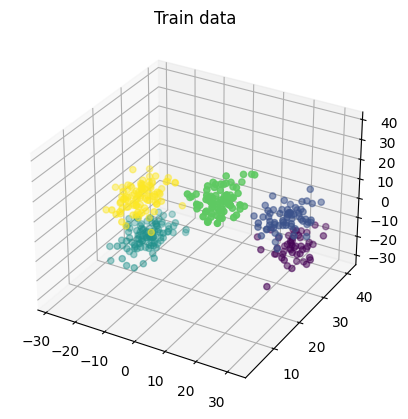

In [108]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=np.random.default_rng(seed),
)

# Plot the train data
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
ax.set_title("Train data");

In [109]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)

In [110]:
# Weight initializer
unif_winit = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=123)

# Using Sequential() to build layers one after another
model = tf.keras.Sequential(
    [
        # Input layer
        tf.keras.layers.Input(shape=(ndims,)),
        # Hidden Layer with 12 units and sigmoid activation
        tf.keras.layers.Dense(
            units=12,
            activation="sigmoid",
            kernel_initializer=unif_winit,
        ),
        # Output Layer with 5 units for 5 classes and sigmoid activation
        tf.keras.layers.Dense(
            units=nclu,
            activation="sigmoid",
            kernel_initializer=unif_winit,
        ),
    ]
)

model.compile(
    loss="MeanSquaredError",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.1),
    metrics=["accuracy"],
)

In [111]:
history = model.fit(
    x=data_train.points,
    y=clunn_train,
    epochs=100,
    batch_size=1,
    shuffle=False,
)

Epoch 1/100
400/400 [==============================] - 0s 392us/step - loss: 0.0857 - accuracy: 0.6100
Epoch 2/100
274/400 [===================>..........] - ETA: 0s - loss: 0.0721 - accuracy: 0.6642  

400/400 [==============================] - 0s 371us/step - loss: 0.0694 - accuracy: 0.6725
Epoch 3/100
400/400 [==============================] - 0s 401us/step - loss: 0.0548 - accuracy: 0.7925
Epoch 4/100
400/400 [==============================] - 0s 378us/step - loss: 0.0441 - accuracy: 0.8775
Epoch 5/100
400/400 [==============================] - 0s 386us/step - loss: 0.0364 - accuracy: 0.9275
Epoch 6/100
400/400 [==============================] - 0s 402us/step - loss: 0.0306 - accuracy: 0.9400
Epoch 7/100
400/400 [==============================] - 0s 370us/step - loss: 0.0261 - accuracy: 0.9650
Epoch 8/100
400/400 [==============================] - 0s 354us/step - loss: 0.0226 - accuracy: 0.9700
Epoch 9/100
400/400 [==============================] - 0s 394us/step - loss: 0.0198 - accuracy: 0.9825
Epoch 10/100
400/400 [==============================] - 0s 380us/step - loss: 0.0176 - accuracy: 0.9825
Epoch 11/100
400/400 [==============================] - 0s 397us/step - loss: 0.0158

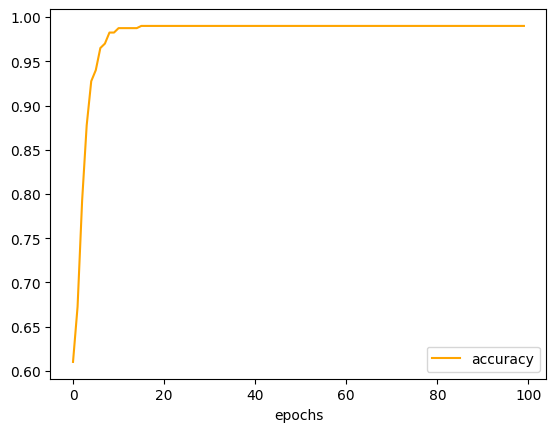

In [112]:
# Showing plot for accuracy
plt.plot(history.history['accuracy'], color='orange')
plt.xlabel('epochs')
plt.legend(['accuracy'])
plt.show()